In [ ]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np


#import pyphysio
import pyphysio as ph
import pandas as pd
import pyphysio.filters.Filters as flt

# (should) show plots in a separate window
%matplotlib inline

In [ ]:
# open file
df_EDA = pd.read_csv('EDA_pp13.csv', header=None)

In [ ]:
n_of_rows = df_EDA.count()
print(n_of_rows)

In [4]:
#actual recording time 64 mins = 3840s
#rows based on seconds 
n_of_rows_keep = 3540*4
print(n_of_rows_keep) #rows we want to keep 

14160


In [5]:
#using pandas to drop all the rows / seconds after 3540s 
df_EDA = df_EDA.drop(df_EDA.index[14160:17820])
print(df_EDA)

              0
0      0.000000
1      0.202316
2      0.295792
3      0.298353
4      0.293231
...         ...
14155  5.509182
14156  5.487414
14157  5.459243
14158  5.450280
14159  5.437907

[14160 rows x 1 columns]


In [6]:
# create the signal
fsamp = 4 #Hz
tstart_df_EDA = 0 #s

In [7]:
eda = ph.EvenlySignal(values = df_EDA.values.ravel(),
                      sampling_freq = fsamp,
                      start_time = tstart_df_EDA)

In [8]:
#count n of rows to get time of recording (s) 
n_of_rows = df_EDA.count()
print(n_of_rows_keep)
#walk time in seconds 
walk_time_seconds = n_of_rows_keep/4
print(walk_time_seconds)
#walk time in minutes
walk_time_minutes = walk_time_seconds/60
print(walk_time_minutes)

# save data 
outputFile=open("time_pp13.txt", 'a')
outputFile.write("{}\n{}\n".format(walk_time_seconds, walk_time_minutes))
outputFile.close()


14160
3540.0
59.0


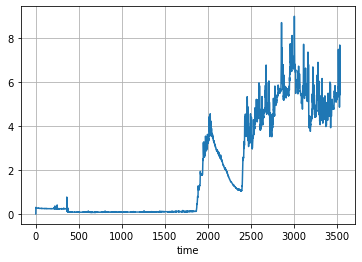

In [9]:
# plot
plot = eda.plot()
# plt.show() #using matplotlib to show the plot

In [10]:
#signal is quite noisy (moving artifacts)
#e.g. simple moving average filter
mov_avg = flt.ConvolutionalFilter('rect', win_len = 1)
eda = mov_avg(eda)

#however, check that you are not losing information


In [11]:
#create baseline (10mins) / label variable
#[0s-600s] #baseline 
#[600s -3480s] #actual recording session 

label = np.zeros(3540)#s
label[0:600] = 1
label[600:3540] = 2

label = ph.EvenlySignal(label, sampling_freq = 1, signal_type = 'label')

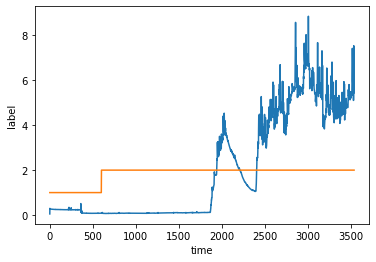

In [12]:
#see also the plots
eda.plot()
label.plot()

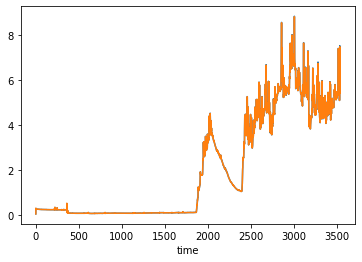

In [13]:
## filtering 
eda_filt = ph.IIRFilter(fp=0.8, fs=1.1, ftype='ellip')(eda)

eda.plot()
eda_filt.plot()

In [14]:
eda = eda_filt

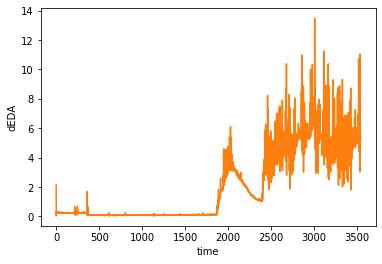

In [15]:
## estimate the driver function 
driver = ph.DriverEstim(t1=.75, t2=2)(eda)
eda.plot()
driver.plot()

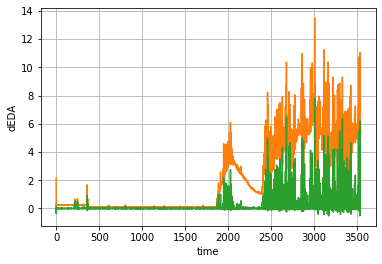

In [16]:
## compute tonic and phasic components
phasic, tonic, tmp_ = ph.PhasicEstim(delta=0.02)(driver)
eda.plot()
driver.plot()
phasic.plot()

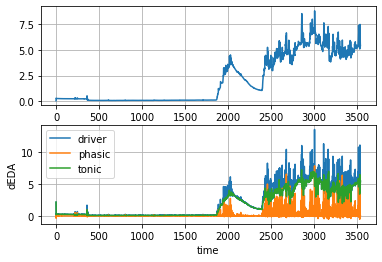

In [17]:
# check results so far
plt.figure() 
ax1 = plt.subplot(211)
eda.plot()
plt.subplot(212, sharex = ax1)
driver.plot()
phasic.plot()
tonic.plot()
plt.legend(['driver', 'phasic', 'tonic'])
plt.show()

In [18]:
## define a list of indicators
indicators_eda = [ph.Mean(name='PhaMean'),
                  ph.StDev(name='StDev'),
                  ph.AUC(name='AUC'),
                  ph.PeaksMean(name='PeaksMean', delta=0.02), 
                  ph.DurationMean(name='DurMean', delta=0.02)]

# you can also use other indicators, however, my suggestion would be to keep it simple and use the usual ones (mean, maximum, range etc)

In [19]:
#fixed length windowing
fixed_length = ph.FixedSegments(step = 60, width = 60, labels = label)                
                  
## compute indicators of phasic signal
#pha_ind, col_names = ph.fmap(fixed_length, ph.preset_phasic(delta=0.02), phasic) #you should use the indicators you listed before
pha_ind, col_names = ph.fmap(fixed_length, indicators_eda, phasic) #you should use the indicators you listed before

In [20]:
#save results into a dataframe
phasic_indicators = pd.DataFrame(pha_ind, columns=col_names)

In [21]:
phasic_indicators.head()

,begin,end,label,PhaMean,StDev,AUC,PeaksMean,DurMean
0,0.0,60.0,1.0,-0.002850,0.041113,-0.170996,0.038244,1.375000
1,60.0,120.0,1.0,0.000291,0.004775,0.017474,0.025032,1.500000
2,120.0,180.0,1.0,-0.000175,0.004283,-0.010489,0.012329,1.500000
3,180.0,240.0,1.0,0.027111,0.067974,1.626688,0.127759,1.423077
4,240.0,300.0,1.0,0.017265,0.060331,1.035900,0.133688,1.472222


In [22]:
phasic_indicators.to_csv('phasicindicators_pp13.csv')

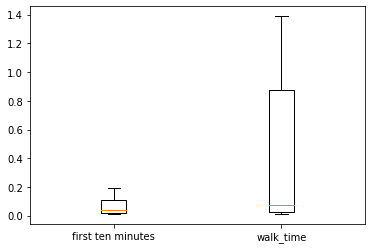

In [23]:
## Box-Whisker plot
# extract column with the labels for each window
label_w = pha_ind[:, np.where(col_names == 'label')[0]]

# extract column with PksMean values
# computed from each window
pksmean_w = pha_ind[:, np.where(col_names == 'PeaksMean')[0]]

pksmean_baseline = pksmean_w[np.where(label_w==1)[0]]
pksmean_walk_time = pksmean_w[np.where(label_w==2)[0]]

## create a boxplot and a whisker plot
## compare the distribution of the RRmean indicator
plt.boxplot([pksmean_baseline, pksmean_walk_time],
              labels=['first ten minutes', 'walk_time'])

import warnings

warnings.simplefilter(action = "ignore", category = RuntimeWarning)
##plt.show()